# Redistricting - Oregon Congressional

### Code used to generate a sample of redistricting plans that optimize for a plan with a Gingles I majority-minority district

****************************

- Least changes map using 2020 5-year ACS population data
- Proritizing the performance of majority-minority districts using 2020 election data

In [22]:
import maup
import pandas as pd
import geopandas as gp
import random
import warnings
warnings.filterwarnings('ignore')

**Load data**

In [23]:
current_cd = gp.read_file("./raw-data/current_map/district-shapes/POLYGON.shp")
acs_bg_shp = gp.read_file("./raw-data/or_race_2022_bg-acs_shp/or_race_2022_bg.shp")
prec_2020 = gp.read_file("./raw-data/or_vest_20/or_vest_20.shp")
blocks_2020 = gp.read_file("./raw-data/or_pl2020_b/or_pl2020_b.shp")
blocks_cvap_2022 = pd.read_csv("./raw-data/or_cvap_2022_2020_b/or_cvap_2022_2020_b.csv")

In [24]:
current_cd = current_cd.to_crs(epsg=32610)
acs_bg_shp = acs_bg_shp.to_crs(epsg=32610)
prec_2020 = prec_2020.to_crs(epsg=32610)
blocks_2020 = blocks_2020.to_crs(epsg=32610) #4326

current_cd["geometry"] = current_cd.buffer(0)
prec_2020["geometry"] = prec_2020.buffer(0)
blocks_2020["geometry"] = blocks_2020.buffer(0)

In [25]:
# km2
current_cd['area_km2'] = current_cd['geometry'].area/ 10**6 
blocks_2020['area_km2'] = blocks_2020["geometry"].area/ 10**6 

In [26]:
### join CVAP data to blocks
blocks_cvap_2022.GEOID20 = blocks_cvap_2022.GEOID20.astype(str)
blocks_2020= blocks_2020.merge(blocks_cvap_2022, on='GEOID20', how='left')

### Prorate data from ACS 2022 Block-Groups to census blocks

In [27]:
pop_columns = [col for col in acs_bg_shp.columns if "22" in col]
bg_to_blocks_assignment = maup.assign(blocks_2020, acs_bg_shp)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / bg_to_blocks_assignment.map(blocks_2020.P0010001.groupby(bg_to_blocks_assignment).sum()).fillna(0)
prorated = maup.prorate(bg_to_blocks_assignment, acs_bg_shp[pop_columns], weights)

blocks_2020[pop_columns] = prorated

### Assign blocks to current enacted congressional plan

In [28]:
bg_to_cd = maup.assign(blocks_2020, current_cd)
blocks_2020['current_cd'] = bg_to_cd

In [29]:
# this pretty much matches Dave's Redistricting counts!
blocks_2020.groupby('current_cd').TOT_POP22.sum()

current_cd
0    703293.192844
1    705168.536867
2    700496.347280
3    705867.371823
4    708473.095047
5    706075.456140
Name: TOT_POP22, dtype: float64

### Prorate Election Data from precincts to blocks

In [30]:
# OTHER vote column
prec_2020['G20PREDOTH'] = prec_2020[[col for col in prec_2020.columns if "PRE" in col and col not in ('G20PREDBID', 'G20PRERTRU', 'PRECINCT')]].sum(axis=1)
prec_2020[[col for col in prec_2020.columns if "PRE" in col]]

,PRECINCT,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,G20PREDOTH
0,4506,2656,717,30,32,6,24,92
1,4409,1613,473,24,22,11,15,72
2,4404,8264,907,106,68,32,80,286
3,4502,3948,482,49,32,9,27,117
4,4501,9190,785,78,36,18,57,189
...,...,...,...,...,...,...,...,...
1326,201,2656,1465,84,13,2,35,134
1327,435,2335,1608,82,18,8,49,157
1328,425,452,550,15,4,1,9,29
1329,13,1091,2040,58,17,5,18,98


In [31]:
elec_columns = ['G20PREDBID', 'G20PRERTRU', 'G20PREDOTH']
prec_2020[elec_columns] = prec_2020[elec_columns].astype(int)
assignment = maup.assign(blocks_2020, prec_2020)
weights_elec = blocks_2020.P0010001  / assignment.map(blocks_2020.P0010001.groupby(assignment).sum()).fillna(0)
prorated_elec = maup.prorate(assignment, prec_2020[elec_columns], weights_elec)

blocks_2020[elec_columns] = prorated_elec

In [32]:
blocks_2020['CVAP_POC'] = blocks_2020[['CVAP_2OM22', 'CVAP_HSP22', 'CVAP_AIA22', 'CVAP_ASN22', 'CVAP_BLK22']].sum(axis=1)

### MCMC Prep

In [33]:
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import json
import numpy as np
plt.style.use('ggplot')

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.tree import bipartition_tree
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import Tally
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, summarize
random.seed(99)

In [34]:
state_abbr = "OH"
state_fip = "39"
num_districts = 6
unique_label = "GEOID20"
pop_col = "TOT_POP22"

In [35]:
# Fill NA values with 0
blocks_2020[blocks_2020.columns[blocks_2020.isna().any()].tolist()] = blocks_2020[blocks_2020.columns[blocks_2020.isna().any()].tolist()].fillna(0)

In [36]:
blocks_2020_select = blocks_2020[['GEOID20', 'current_cd', 'area_km2', 'TOT_POP22', 'CVAP_TOT22', 'CVAP_POC', 'G20PREDBID', 'G20PRERTRU', 'G20PREDOTH', 'geometry']]

In [37]:
# create graph
graph = Graph.from_geodataframe(blocks_2020_select)
graph.add_data(blocks_2020_select,list(blocks_2020_select))

In [38]:
# population check
TOTPOP = sum(graph.nodes()[n]['TOT_POP22'] for n in graph.nodes())
print(TOTPOP)
blocks_2020.TOT_POP22.sum()

4229373.999999991


4229374.0

In [39]:
import polars as pl
class PartValue:
    def __init__(self, col=None, state=state_abbr, num=None):
        self.col = col
        self.state = state
        self.num = num

    def get_val(self, partition):
        return list(map(lambda x: partition.graph.nodes[x].get(self.col), range(blocks_2020.shape[0])))
    
    def new_districts(partition):
        return list(map(lambda x: partition.assignment[x], range(blocks_2020.shape[0])))
    
    def displacement(self, partition):
        c = []
        for inx, (i,j) in enumerate(zip(partition['new_districts'], partition['current_cds'])):
            if int(i) != int(j):
                c.append(partition.graph.nodes[inx].get(self.col))
        return(sum(c))
    
class SavePart:
    def __init__(self, state=state_abbr, num=None, dir = None):
        self.state = state
        self.num = num
        self.dir = dir
        
    def save_assignment(self, partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_cds = PartValue.new_districts(partition)
        assignment_df = pl.DataFrame({
                "GEOID20": geos_ids,
                "CD": new_cds}
            )
        output_name = f"{self.state}_part_{str(self.num)}.txt",
        if self.dir is not None:
            output_name = f"{self.dir}/{self.state}_part_{str(self.num)}.txt"
        return(assignment_df.write_csv(output_name, separator=","))


In [40]:
updater = {
    "population": updaters.Tally("TOT_POP22", alias="population"),
    "cvap": updaters.Tally("CVAP_TOT22", alias="cvap"),
    "cvap_poc": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "2020_pres" : Election("2020_pres", {"G20PRERTRU":"G20PRERTRU","G20PREDBID":"G20PREDBID","G20PREDOTH":"G20PREDOTH"}, alias="2020_pres"),
    "area": updaters.Tally("area_km2", alias="area"),
    "new_districts": PartValue.new_districts,
    "current_cds" : PartValue(col='current_cd').get_val,
    "pop_change" : PartValue(col='TOT_POP22').displacement,
    "area_change" : PartValue(col='area_km2').displacement,
    
}

initial_partition = Partition(
    graph,
    assignment="current_cd",
    updaters=updater
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    # propose_random_flip,
    recom,
    pop_col="TOT_POP22",
    pop_target=ideal_population,
    epsilon=.0075,
    node_repeats=1,
    method = partial(
        bipartition_tree,
        max_attempts=5,
        allow_pair_reselection=True 
    )
)

### Gingles I optimizer -- optimize for plans that create a Gingles I district

In [ ]:
gingles_optimizer = Gingleator(
    proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    minority_pop_col="cvap_poc",
    total_pop_col="cvap",
    score_function=Gingleator.reward_partial_dist
)

random.seed(2024)

In [44]:
tot_pop = []
cvap_pop = []
cvap_poc = []
pres20 = []

areas = []
people_change = []
area_change = []

gingles_scores = []
poc_props = []

dem_seats_pres = []
rep_seats_pres = []

pop_dev = []

t = 0
min_scores_sb = []
with open("./output_gingles/OR_gingles_output.jsonl", "w") as f:
    for i, part in enumerate(gingles_optimizer.short_bursts(5, 2000, with_progress_bar=True)):
        min_scores_sb.append(gingles_optimizer.best_score)
        
        tot_pop.append(part["population"])
        cvap_pop.append(part["cvap"])
        cvap_poc.append(part["cvap_poc"])
        
        dev = abs((min(part["population"].values()) / ideal_population) - (max(part["population"].values()) / ideal_population))
        pop_dev.append(dev)
        
        areas.append(part["area"])
        people_change.append(part["pop_change"])
        area_change.append(part["area_change"])

        pres20.append(part["2020_pres"].percents("G20PREDBID"))
        dem_seats_pres.append(part["2020_pres"].wins("G20PREDBID"))
        rep_seats_pres.append(part["2020_pres"].wins("G20PRERTRU"))
        
        pp = demographic_shares({"cvap": ["cvap_poc"]})[0].apply(part)
        gd = gingles_districts({"cvap": ["cvap_poc"]}, threshold=0.5)[0].apply(part)
        poc_props.append(pp)
        gingles_scores.append(gd)

        if gd > 0 and dev < .0075:
            SavePart(num=t, dir='./output_gingles/').save_assignment(part)

        t +=1
        data = {
            "step": t,
            "populations": part["population"],
            "areas": part["area"],
            "areas_change": part["area_change"],
            "pops_change":part["pop_change"],
            "cvap_poc_prop": pp,
            "cvap_tot": part["cvap"],
            "gingles_districts" : gd
        }
            
        # Add newline character to separate entries in JSONL file
        f.write(json.dumps(data) + "\n")

Python(32969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 10000/10000 [24:01:34<00:00,  8.65s/it]  


**It is impossible to create a plan that allows for a Gingles I district**

(array([2.000e+00, 4.000e+00, 3.000e+00, 1.000e+01, 3.000e+00, 3.100e+01,
        1.290e+02, 2.010e+02, 3.100e+02, 3.950e+02, 2.480e+02, 1.350e+02,
        5.800e+01, 4.700e+01, 5.000e+01, 2.100e+01, 1.100e+01, 7.000e+00,
        6.000e+00, 1.000e+01, 3.400e+01, 2.100e+01, 3.600e+01, 3.800e+01,
        1.510e+02, 3.540e+02, 8.450e+02, 1.571e+03, 2.170e+03, 3.099e+03]),
 array([     0.        ,   8500.46919943,  17000.93839885,  25501.40759828,
         34001.8767977 ,  42502.34599713,  51002.81519655,  59503.28439598,
         68003.7535954 ,  76504.22279483,  85004.69199426,  93505.16119368,
        102005.63039311, 110506.09959253, 119006.56879196, 127507.03799138,
        136007.50719081, 144507.97639023, 153008.44558966, 161508.91478909,
        170009.38398851, 178509.85318794, 187010.32238736, 195510.79158679,
        204011.26078621, 212511.72998564, 221012.19918507, 229512.66838449,
        238013.13758392, 246513.60678334, 255014.07598277]),
 <BarContainer object of 30 artists

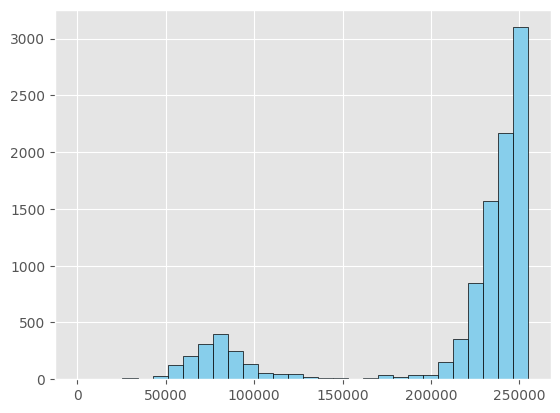

In [46]:
plt.hist(area_change, bins=30, color='skyblue', edgecolor='black')